## International Space Station
The ISS programme is a joint project between five participating space agencies: NASA (United States), Roscosmos (Russia), JAXA (Japan), ESA (Europe), and CSA (Canada). The ownership and use of the space station is established by intergovernmental treaties and agreements.

The ISS serves as a microgravity and space environment research laboratory in which crew members conduct experiments in biology, physics, astronomy, and other fields.


# ISS Live Feed
http://open-notify.org/


In [1]:
from pytrends.request import TrendReq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import Image

# How Many People Are In Space Right Now?

In [2]:
# http://api.open-notify.org/astros.json
# This API returns the current number of people in space. 
# When known it also returns the names and spacecraft those people are on. This API takes no inputs.

import requests
myReq = requests.get(url='http://api.open-notify.org/astros.json')
result = myReq.json()

if(result['message'] == 'success'):
    numberOfPeopleInSpace = result['number']
    craft = result['people'][0]['craft']
    listOfAstro = [i['name'] for i in result['people']]


# Where is the International Space Station right now?

In [3]:
# http://api.open-notify.org/iss-now.json

myReq = requests.get(url='http://api.open-notify.org/iss-now.json')
result = myReq.json()

ISS_lat = result['iss_position']['latitude']
ISS_lon = result['iss_position']['longitude']
ISS_timestamp = result['timestamp']

print(ISS_lat,ISS_lon)

# Get name of the Place using reverse-geocode
# importing necessary libraries 

import reverse_geocoder as rg  
coordinates =(float(ISS_lat),float(ISS_lon))
place = rg.search(coordinates)
print(place[0]['name'],place[0]['cc'],place[0]['admin1'],place[0]['admin2'])


-48.8378 -92.9488
Loading formatted geocoded file...
Chonchi CL Los Lagos Provincia de Chiloe


# Plot the ISS Current Location

Text(0.5, 1.0, 'International Space Station Current Location')

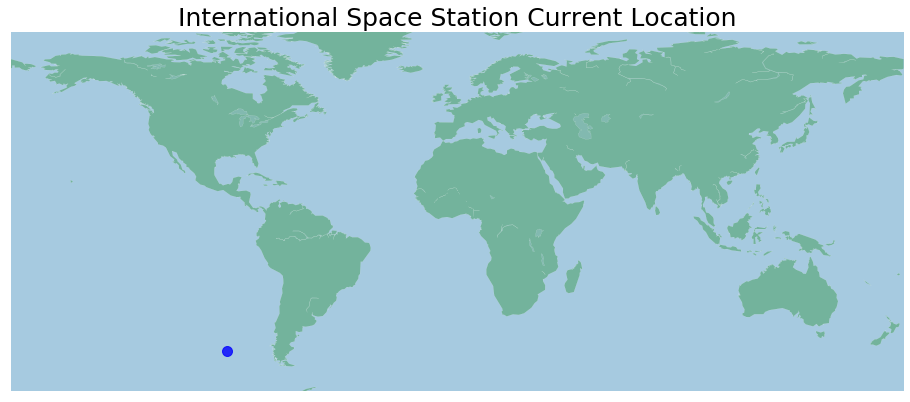

In [4]:
# pip install Basemap

import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap

# Set the dimensions of the figure
plt.figure(figsize=(16,8))

# Make the background map
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='green', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")

# Mark the current Location of ISS
m.scatter(float(ISS_lon), float(ISS_lat), 
          s=100, alpha=0.8,color='blue')

plt.title('International Space Station Current Location',fontsize=25)

# Collect Location Data for 1 revolution around the Earth


In [8]:
import datetime
import time

record_data = True

if record_data == True:
    #date_to_print = datetime.datetime.now().strftime("%Y%m%d")
    starttime=time.time()

    ISS_data = []
    
    while True: 
        req = requests.get(url='http://api.open-notify.org/iss-now.json')
        result = (req.json())

        ISS_data.append([result['timestamp'],
                                result['iss_position']['latitude'],
                                result['iss_position']['longitude']
                                ])

        
        # create a csv file for collecting data
        ISS_data_df = pd.DataFrame(ISS_data, columns=['timestamp','latitude', 'longitude'])
        ISS_data_df.to_csv('ISS_location_data1.csv', index=None)
        
        # Stop Condition
        if len(ISS_data) > 110:
            break
            
        # let it sleep 60 seconds
        time.sleep(60.0 - ((time.time() - starttime) % 60.0))

# Visualize the Historical Data

In [5]:
# Load the Historical Data
ISS_flight_data = pd.read_csv('ISS_location_data.csv')

# Translate timestamp into readable format
from datetime import datetime
date_time = [datetime.fromtimestamp(i) for i in ISS_flight_data['timestamp']]

# Add date and time as a new column in the dataframe 
ISS_flight_data['DateTime'] = date_time

# add an plot size from oldest to newest
ISS_flight_data['index'] = range(1,len(ISS_flight_data)+1)
 
ISS_flight_data.head()

,timestamp,latitude,longitude,DateTime,index
0,1595830554,-23.4722,90.6371,2020-07-27 11:45:54,1
1,1595830614,-20.6158,93.1658,2020-07-27 11:46:54,2
2,1595830674,-17.6918,95.6117,2020-07-27 11:47:54,3
3,1595830734,-14.7317,97.9708,2020-07-27 11:48:54,4
4,1595830794,-11.7429,100.2596,2020-07-27 11:49:54,5


# Modelling the ISS Data

Intercept:  -83.6570584903272
Slope:  0.9858024016218154
Predicted Latitude for  108 :  22.809600884828868


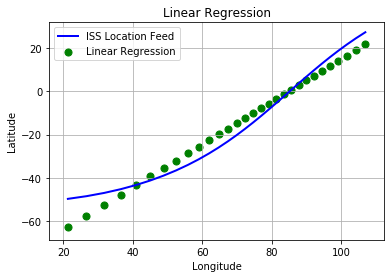

In [32]:
# Each dot on the map denotes one minute
# let's try to predict the future course of ISS

# USING LINEAR REGRESSION

# Dataset for Training
ISS_train_set = ISS_flight_data.tail(30)

from scipy import stats
slope, intercept, r_val, p_val, std_err = stats.linregress(x=ISS_train_set['longitude'],y=ISS_train_set['latitude'])

print('Intercept: ',intercept)
print('Slope: ',slope)
predefined_long = 108
predicted_value_LR = slope * predefined_long + intercept
print('Predicted Latitude for ',predefined_long,': ',predicted_value_LR)

# Comparison between for dataset and Trained model using Linear Regression
plt.plot(ISS_train_set['longitude'],ISS_train_set['latitude'],label='ISS Location Feed',linewidth=2,c='blue')
plt.scatter(ISS_train_set['longitude'],slope*ISS_train_set['longitude']+intercept,c='green',label='Linear Regression',s=50)
plt.title('Linear Regression')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()

Predicted Latitude for Longitude  108 :  27.97233769903353


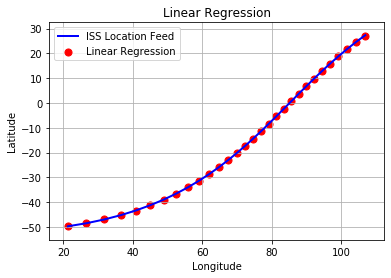

In [33]:
# USING POLYNOMIAL REGRESSION

x = ISS_train_set['longitude']
y = ISS_train_set['latitude']
poly_regression = np.poly1d(np.polyfit(x, y, 5))

# Predict Latitude
predicted_latitude_PR =  poly_regression(predefined_long)
print('Predicted Latitude for Longitude ',predefined_long,': ',predicted_latitude_PR)

# Comparison between for dataset and Trained model using Linear Regression
plt.plot(ISS_train_set['longitude'],ISS_train_set['latitude'],label='ISS Location Feed',linewidth=2,c='blue')
plt.scatter(ISS_train_set['longitude'],poly_regression(ISS_train_set['longitude']),c='red',label='Linear Regression',s=50)
plt.title('Linear Regression')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()

# Plotting the Predicted values obtained using Linear and Polynomial    Regression

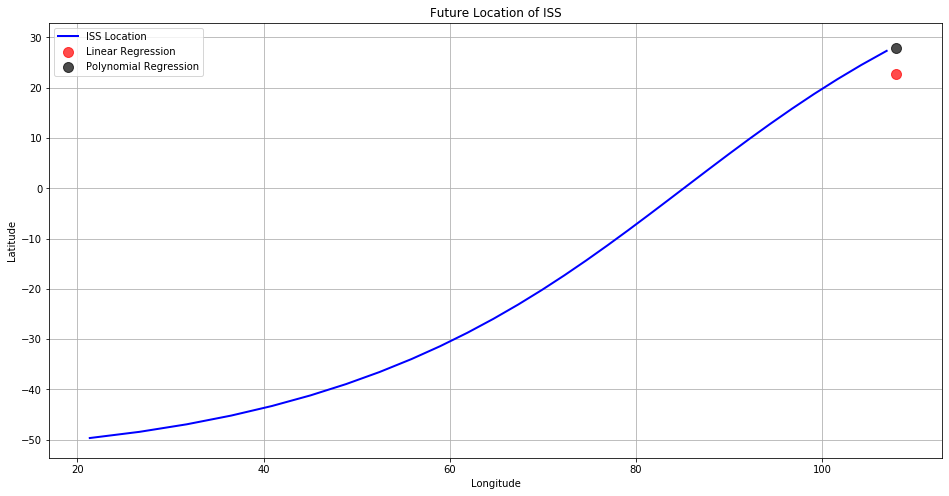

In [48]:
# Let's decide which model predicts the best value
plt.figure(figsize=(16,8))
plt.plot(ISS_train_set['longitude'],ISS_train_set['latitude'],label='ISS Location',linewidth=2,c='blue')
plt.title('Future Location of ISS')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()

plt.scatter(predefined_long,predicted_value_LR,s=100,alpha=0.7,color='red',label='Linear Regression')
plt.scatter(predefined_long,predicted_latitude_PR,s=100,alpha=0.7,color='black',label='Polynomial Regression')
plt.legend()



In [9]:
# From the Visualization, it is concluded that the Polynomial Regression best fits the data.
# It gives accurate results for any value

# ACTUAL PATH of the ISS versus the PREDICTED PATH

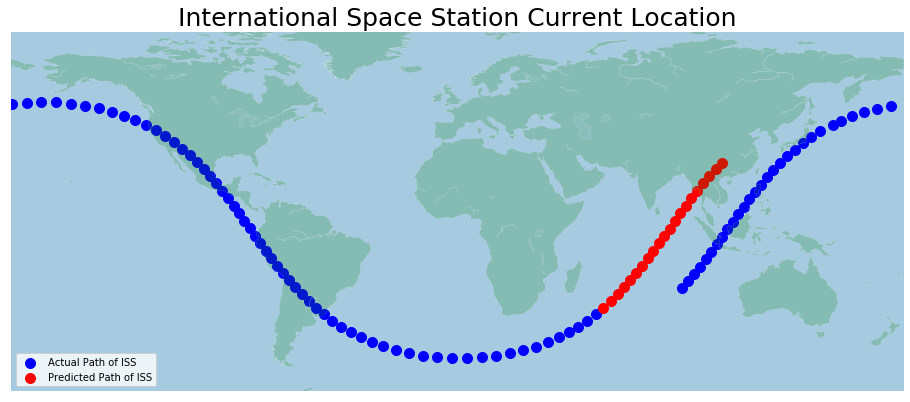

In [87]:
# Set the dimensions of the figure
plt.figure(figsize=(16,8))

# Make the background map
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='green', alpha=0.2)
m.drawcoastlines(linewidth=0.1, color="white")


# Mark the Actual Path of ISS
m.scatter((ISS_flight_data['longitude'][:90]), 
          (ISS_flight_data['latitude'][:90]), 
          s=100, alpha=1,color='blue',label='Actual Path of ISS')

# Mark the Predicted Path of ISS
# Using Trained Polynomial Regression Model
m.scatter((ISS_flight_data['longitude'][90:]), 
          (poly_regression(ISS_flight_data['longitude'][90:])), 
          s=100, alpha=1,color='red',label='Predicted Path of ISS')


plt.title('International Space Station Current Location',fontsize=25)
plt.legend()

# Realtime ISS Live Feed

Enter the time in seconds for Live Watch15


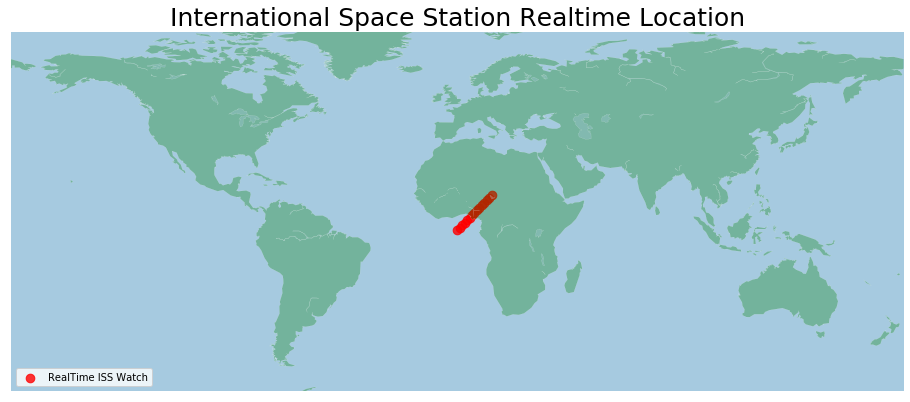

In [107]:
# Plotting RealTime Location
import time

# Enter the seconds for which you want to see the Livefeed
timeReq = int(input('Enter the time in seconds for Live Watch'))

# Set the dimensions of the figure
fig = plt.figure(figsize=(16,8))

# Make the background map
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='green', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
plt.title('International Space Station Realtime Location',fontsize=25)

# Mark the current Location of ISS

xs = []
ys = []
for i in range(0,timeReq,1):
    myReq = requests.get(url='http://api.open-notify.org/iss-now.json')
    result = myReq.json()
    ISS_lat = result['iss_position']['latitude']
    ISS_lon = result['iss_position']['longitude'] 
    xs.append(ISS_lon)
    ys.append(ISS_lat)
    time.sleep(1)
    
m.scatter(xs,ys,s=75, alpha=0.8,color='red',label='RealTime ISS Watch')
plt.legend()
    